In [35]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import tensorflow as tf
import numpy as np

import os

matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize

# Creating and sampling two distributions.
We will seek to develop a model for inferring the probabilities based on two sets of data with differing numbers of samples from each.

In [36]:
#two probabilities
trueA = 0.09
trueB = 0.18

#two different sample sizes for the probabilities
samplesA = 1500
samplesB = 700

#generate some data
obsA = tfd.Bernoulli(probs=trueA).sample(sample_shape=samplesA, seed=10)
obsB = tfd.Bernoulli(probs=trueB).sample(sample_shape=samplesB, seed=10)


print("Obs from Site A: ", obsA[:30], "...")
print("Observed Prob_A: ", np.mean(obsA), "...")
print("Obs from Site B: ", obsB[:30], "...")
print("Observed Prob_B: ", np.mean(obsB))

Obs from Site A:  tf.Tensor([0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(30,), dtype=int32) ...
Observed Prob_A:  0.08533333333333333 ...
Obs from Site B:  tf.Tensor([0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0], shape=(30,), dtype=int32) ...
Observed Prob_B:  0.18857142857142858


# Joint Log Probability
This function evaluates the log of the joint probability that the model generated the observed data.  

The Markov chain Monte Carlo (MCMC) algorithm guesses at unknown input values and calculates how likely its set of arguments is.

In [37]:
def double_joint_log_prob(obsA, obsB, 
                probA, probB):

    rv_prob_A = tfd.Uniform(low=0., high=1.)
    rv_prob_B = tfd.Uniform(low=0., high=1.)

    rv_obs_A = tfd.Bernoulli(probs=probA)
    rv_obs_B = tfd.Bernoulli(probs=probB)

    probability = (rv_prob_A.log_prob(probA)
        + rv_prob_B.log_prob(probB)
        + tf.reduce_sum(rv_obs_A.log_prob(obsA))
        + tf.reduce_sum(rv_obs_B.log_prob(obsB)))

    return probability

In [38]:
#joint log returns something like a gradient, you can explore the value changing as you modify the mean.
double_joint_log_prob(obsA, obsB, obsMeanA-0.03,obsMeanB)

<tf.Tensor: shape=(), dtype=float32, numpy=-804.8071>

## Setting parameters for MCMC
Chain initial state is where we will start exploring the space.  We'll use the mean of the observations.

In [39]:
number_of_steps = 30000 
burnin = 8000 
leapfrog_steps=5


# Set the chain's start state.
initial_chain_state = [    
    tf.reduce_mean(tf.cast(obsA,tf.float32)),
    tf.reduce_mean(tf.cast(obsB,tf.float32))
]


# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: double_joint_log_prob(obsA, obsB, *args)

In [40]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_posterior_log_prob,
                 step_size=0.065,
                 num_leapfrog_steps=leapfrog_steps)

## Sample the Chain
Generate samples from our chain

In [41]:
# Apply a simple step size adaptation during burnin
@tf.function
def run_chain():
  adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc_kernel,
      num_adaptation_steps=int(.8 * burnin),
      target_accept_prob=np.float64(.65))

  return tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=adaptive_kernel,
    trace_fn=lambda cs, kr: kr)

In [42]:
samples, kernel_results = run_chain()

In [43]:
samples[0]

<tf.Tensor: shape=(30000,), dtype=float32, numpy=
array([0.09670097, 0.07801462, 0.09191581, ..., 0.07559809, 0.07559809,
       0.09108955], dtype=float32)>

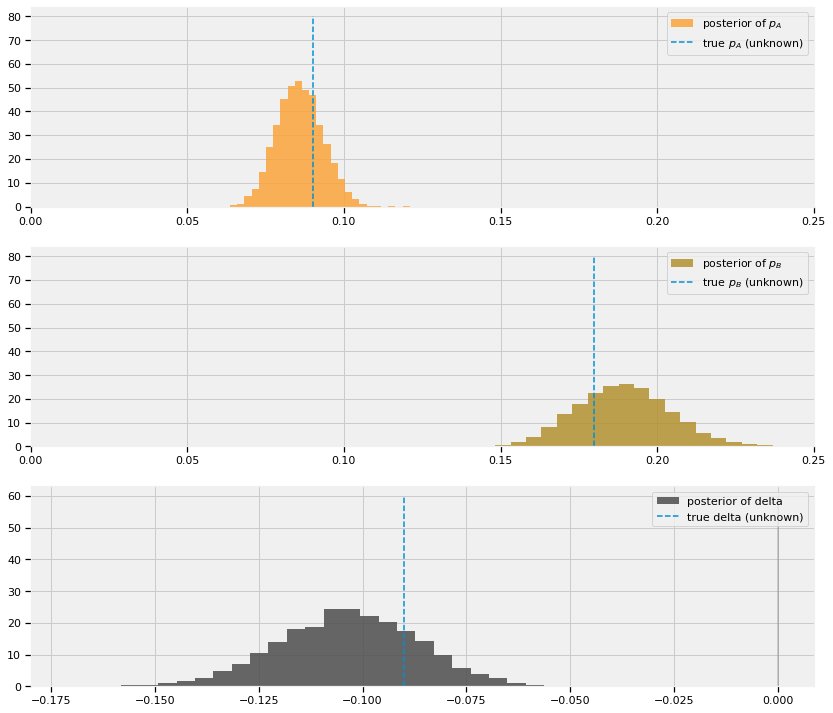

In [44]:
plt.figure(figsize(12.5, 12.5))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .25)
plt.hist(samples[0].numpy(), histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color='#FAA43A', density=True)
plt.vlines(trueA, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(312)

plt.xlim(0, .25)
plt.hist(samples[1].numpy(), histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color='#B2912F', density=True)
plt.vlines(trueB, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist((samples[0]-samples[1]).numpy(), histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color='#4D4D4D', density=True)
plt.vlines(trueA - trueB, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

## Bijectors
Map the values to a constrained space, this can help convergence.

In [45]:
unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity()]

In [46]:
# Apply a simple step size adaptation during burnin
@tf.function
def run_chain():
  adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      tfp.mcmc.TransformedTransitionKernel(
            inner_kernel= hmc_kernel,
            bijector=unconstraining_bijectors),
      num_adaptation_steps=int(.8 * burnin),
      target_accept_prob=np.float64(.65))

  return tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=adaptive_kernel,
    trace_fn=lambda cs, kr: kr)

In [47]:
samples, kernel_results = run_chain()

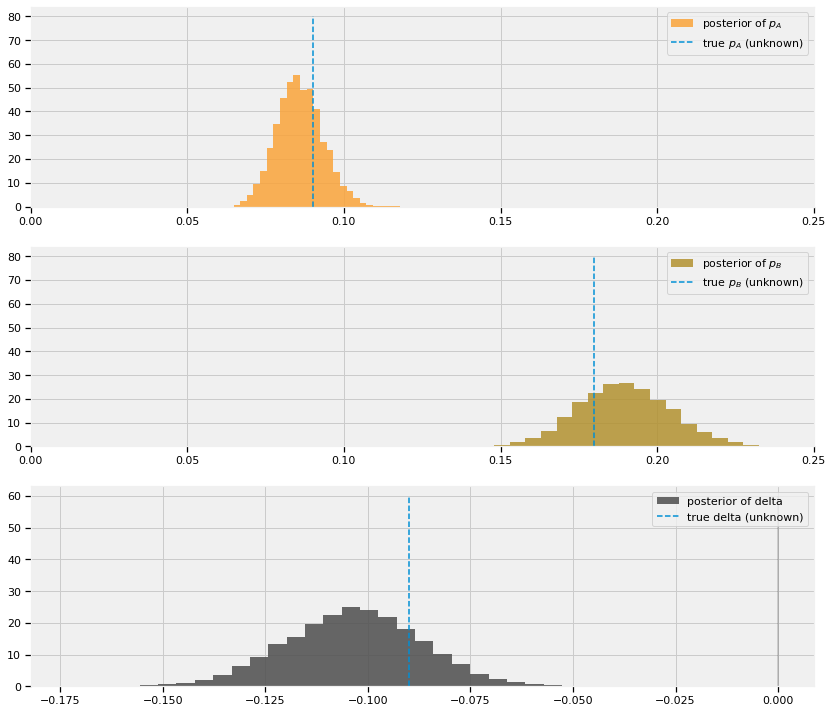

In [48]:
plt.figure(figsize(12.5, 12.5))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .25)
plt.hist(samples[0].numpy(), histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color='#FAA43A', density=True)
plt.vlines(trueA, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(312)

plt.xlim(0, .25)
plt.hist(samples[1].numpy(), histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color='#B2912F', density=True)
plt.vlines(trueB, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist((samples[0]-samples[1]).numpy(), histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color='#4D4D4D', density=True)
plt.vlines(trueA - trueB, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");